# **AI Coursework 2**

I've chosen to do the Generative project using deep dream from tensorflow for my project. This basically just recognizes the patterns it sees in an image an enhances them.

In [ ]:
import tensorflow as tf

In [ ]:
import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image


import matplotlib.pyplot as plt
import os, pathlib
from tensorflow import keras 
import os
import sys

In [ ]:
# Colab code to mount your drive
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


Choose Image

I've chosen to use an image from wikipedia which is an opensource platform.

In [ ]:
 url = 'https://upload.wikimedia.org/wikipedia/commons/8/86/Cat_yawning_in_park.jpg'

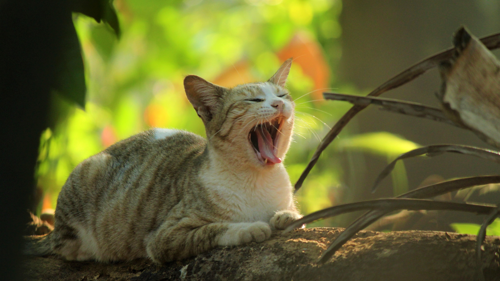

In [ ]:
# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path) 
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image by converting it to a PIL image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


# Downsizing the image makes it easier to work with.
original_img = download(url, max_dim=500)
show(original_img)
display.display(display.HTML('Image cc-by: <a "https://commons.wikimedia.org/wiki/File:Cat_yawning_in_park.jpg">Eatcha</a>'))

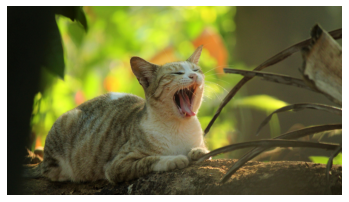

In [ ]:
# Cell for an attempt to make a directory to download warpped images to 
basedir = pathlib.Path("deep-dream")
if not basedir.is_dir():
    os.mkdir("deep-dream")

base_image_path = tf.keras.utils.get_file(

    "cat.jpg",
    origin = "https://upload.wikimedia.org/wikipedia/commons/8/86/Cat_yawning_in_park.jpg",

    cache_dir=basedir,
    cache_subdir="",
)

plt.axis("off")
plt.imshow(tf.keras.utils.load_img(base_image_path))

Prepare Feature Extraction

This is creating an instance of the pretrained model on the ImageNet database from tensorflow. So its weights will be initialized with the values learned from that training process.

In [ ]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet') 
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_658 (Conv2D)            (None, None, None,   864         ['input_8[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization_658 (Batch  (None, None, None,   96         ['conv2d_658[0][0]']             
 Normalization)                 32)                                                    

This code creates a new model, named "dream_model", for feature extraction. The "names" list contains the names of the layers in the base InceptionV3 model that we want to maximize the activations of. The "layer_settings" dictionary maps these layer names to the respective scaling factors for their activations.

The "layers" list is created by extracting the output of the specified layers in the base InceptionV3 model using the "base_model.get_layer(name).output" expression for each layer name in the "names" list.

Finally, the "dream_model" is created by passing the base model's input and the extracted layers as arguments to the "tf.keras.Model" constructor. This creates a new model that has the same input as the base model but only outputs the activations of the specified layers.

In [ ]:
# Maximize the activations of these layers
names = ['mixed2', 'mixed6']
layer_settings = {
    "mixed2": 0.5,
    "mixed6": 3.5
}
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

Calculate Loss

This code defines a function named "calc_loss" which calculates the loss of an image given a model. The function takes two arguments: "img", which is the image and "model", which is the feature extraction model.

The function starts by using the "tf.expand_dims" function to convert the input image into a batch of size 1, which is required for inputting the image into the model. Then, it passes the image through the model to retrieve the activations of the specified layers using the "model(img_batch)" expression.

Next, the function checks if the number of activations retrieved from the model is equal to 1. If it is, it wraps the activations in a list to ensure that it can handle the activations as a list in the next steps.

The function then calculates the mean of each activation and appends it to the "losses" list. Finally, the function returns the sum of all the losses using the "tf.reduce_sum" function.

In [ ]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

Gradient Ascent

The code above defines a class DeepDream that implements the deep dream algorithm. The class is a sub-class of the TensorFlow module and it is defined using the tf.Module decorator.

The class has an __init__ method that takes in a single argument model, which is the feature extraction model defined in the previous code snippet. The class has a call method __call__ that takes in three arguments: img, steps, and step_size.

The img argument is a TensorFlow tensor that represents the image to be processed. The steps argument is an integer representing the number of gradient ascent steps to take, and the step_size argument is a float that represents the magnitude of the update to the image in each gradient ascent step.

The __call__ method uses a tf.GradientTape context to record operations for automatic differentiation. In each iteration of the for-loop, the gradient of the calc_loss with respect to the pixels of the input image is calculated. The gradients are then normalized and added to the image to maximize the loss, which represents how much the image activates the desired layers in the feature extraction model. The process continues for steps iterations. Finally, the final loss and the modified image are returned.

In [ ]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 
        
        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

The code first creates an instance of the DeepDream class and assigns it to a variable deepdream. The DeepDream class is created using the tf.Module class, which is part of the TensorFlow API. The DeepDream class takes a model as an argument and stores it as an attribute of the class.

The deepdream instance is then called with steps and step_size arguments. The __call__ method in the DeepDream class uses tf.function to define a TensorFlow graph that can be executed as a computation. The method uses the GradientTape context to calculate the gradients of the loss with respect to the input image and update the image by adding the gradient scaled by the step_size.

Finally, the code calls the summary method of the dream_model to print a summary of the model's architecture.





In [ ]:
deepdream = DeepDream(dream_model)
dream_model.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_658 (Conv2D)            (None, None, None,   864         ['input_8[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization_658 (Batch  (None, None, None,   96         ['conv2d_658[0][0]']             
 Normalization)                 32)                                                         

Main Loop

In [ ]:
def run_deep_dream_simple(img, steps=120, step_size=0.02):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>120:
      run_steps = tf.constant(120)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))
    
    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

We can see here how high steps and low step size keep our cat very visable with some minor brush strokes on top.

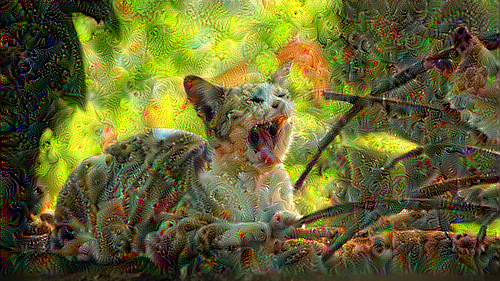

In [ ]:
dream_img = run_deep_dream_simple(img=original_img, 
                                  steps=200, step_size=0.01) # we can consider the steps as our learning rate

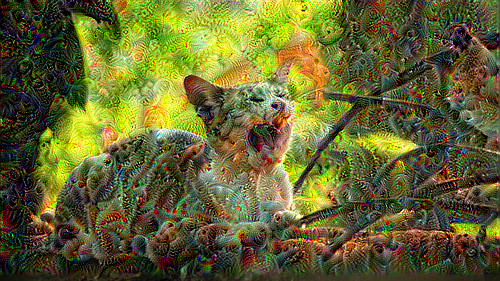

In [ ]:
dream_img = run_deep_dream_simple(img=original_img, 
                                  steps=120, step_size=0.02) # we can consider the steps as our learning rate

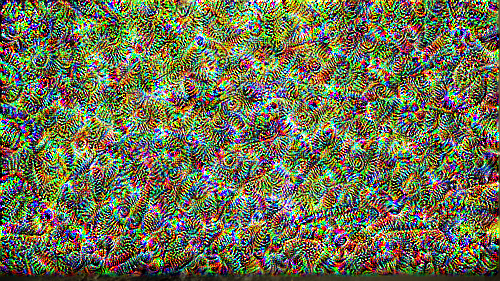

In [ ]:
dream_img = run_deep_dream_simple(img=original_img, 
                                  steps=50, step_size=0.2) 

Here we can see with low steps and high step sizes, the patters have been supercharged and our cat is no longer recognisable in the patterns.

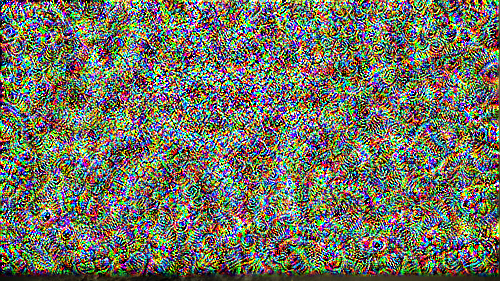

In [ ]:
dream_img = run_deep_dream_simple(img=original_img, 
                                  steps=20, step_size=0.5) 

In [ ]:
# Attempt to save, I can's seem to solve the directory issue
plt.imshow(tf.keras.utils.load_img(basedir/'dream_img.jpg'))

Increasing Octave

The code runs deep dream on the original_img by first resizing it to different scales, each OCTAVE_SCALE times larger than the previous one. The resized images are then passed through run_deep_dream_simple method to run deep dream. The final image is then resized back to its original shape and converted to an 8-bit image format before being displayed. The execution time is calculated as the difference between the end time and start time.

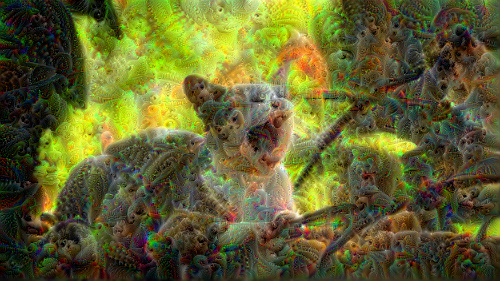

15.600508213043213

In [ ]:
import time
start = time.time()

OCTAVE_SCALE = 1.50

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

  img = tf.image.resize(img, new_shape).numpy()

  img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

end = time.time()
end-start

Scaling with Tiles

We're introduing some variation of a different kind to our cat here. Shifting the axis has also shifted colours.

A function random_roll that takes as input an image img and a maximum shift value maxroll. The function uses tf.random.uniform to generate two random integers within the range [-maxroll, maxroll], which are then used to shift the image along the 2nd and 0th axes using tf.roll. The shift values and the rolled image are then returned

In [ ]:
def random_roll(img, maxroll):
  # Randomly shift the image to avoid tiled boundaries.
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  img_rolled = tf.roll(img, shift=shift, axis=[2,0])
  return shift, img_rolled

it should return a tuple of (shift, img_rolled). The shift is a 1-D tensor with shape [2] containing the values that img has been rolled along the axis [2,0]. The img_rolled is a tensor of the same shape as img, which contains the values of img after being rolled by the given shift.

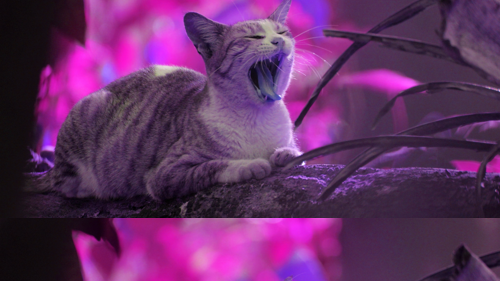

In [ ]:
shift, img_rolled = random_roll(np.array(original_img), 512)
show(img_rolled)

Tiled Deep dream func

The code defines a TiledGradients class that can be used to calculate the gradients of a model's activations with respect to an input image. The gradients are calculated by extracting tiles from the image and computing the gradients of a loss function with respect to each tile. The gradients are then combined to form the gradients of the model's activations with respect to the entire image.

In [ ]:
class TiledGradients(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[2], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.int32),)
  )
  def __call__(self, img, img_size, tile_size=512):
    shift, img_rolled = random_roll(img, tile_size)

    # Initialize the image gradients to zero.
    gradients = tf.zeros_like(img_rolled)
    
    # Skip the last tile, unless there's only one tile.
    xs = tf.range(0, img_size[1], tile_size)[:-1]
    if not tf.cast(len(xs), bool):
      xs = tf.constant([0])
    ys = tf.range(0, img_size[0], tile_size)[:-1]
    if not tf.cast(len(ys), bool):
      ys = tf.constant([0])

    for x in xs:
      for y in ys:
        # Calculate the gradients for this tile.
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img_rolled`.
          # `GradientTape` only watches `tf.Variable`s by default.
          tape.watch(img_rolled)

          # Extract a tile out of the image.
          img_tile = img_rolled[y:y+tile_size, x:x+tile_size]
          loss = calc_loss(img_tile, self.model)

        # Update the image gradients for this tile.
        gradients = gradients + tape.gradient(loss, img_rolled)

    # Undo the random shift applied to the image and its gradients.
    gradients = tf.roll(gradients, shift=-shift, axis=[0,1])

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 

    return gradients 

TiledGradients is a custom class that extends the functionalities of the dream_model class. The purpose of this class is to calculate the gradient of the image with respect to the activations of a particular layer in the dream_model.

By creating an instance of the TiledGradients class and passing dream_model as an argument, we are initializing the instance with the desired model.

The method get_tiled_gradients is then used to calculate the gradient of the image with respect to the activations of the specified layer in dream_model.

It should be noted that get_tiled_gradients is a method of the TiledGradients class, and TiledGradients(dream_model) creates an instance of the TiledGradients class with the dream_model passed as an argument.

In [ ]:
get_tiled_gradients = TiledGradients(dream_model)

Scalable, octave aware amalgamation 

This code performs a deep dream operation on the input image using octave-based scaling. The deep dream is performed by repeating the following steps:

Preprocess the input image using the preprocess_input function from the InceptionV3 model.
Scale the image based on the octave.
Perform the deep dream step by:
a. Obtaining the gradients of the image using the get_tiled_gradients function.
b. Updating the image by adding the gradients with a scaling factor equal to the step size.
c. Clipping the values of the image to the range [-1, 1].
If the current step is a multiple of 10, the intermediate result is displayed.
Repeat steps 3 and 4 for the specified number of steps per octave.
Repeat steps 2 to 5 for each octave specified in the octaves list.
The final result is deprocessed using the deprocess function and returned.

In [ ]:
def run_deep_dream_with_octaves(img, steps_per_octave=110, step_size=0.01, 
                                octaves=range(-2,3), octave_scale=1.3):
  base_shape = tf.shape(img)
  img = tf.keras.utils.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  initial_shape = img.shape[:-1]
  img = tf.image.resize(img, initial_shape)
  for octave in octaves:
    # Scale the image based on the octave
    new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
    new_size = tf.cast(new_size, tf.int32)
    img = tf.image.resize(img, new_size)

    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(img, new_size)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

      if step % 10 == 0:
        display.clear_output(wait=True)
        show(deprocess(img))
        print ("Octave {}, Step {}".format(octave, step))
    
  result = deprocess(img)
  return result

This block of code is generating a deep dream image using a pre-trained Inception V3 model.

The function run_deep_dream_with_octaves is called with the original image (original_img) and the step size (0.01) as arguments. This function generates a deep dream image by processing the image through multiple octaves (different scales) of the Inception V3 model.

The input image is first preprocessed using tf.keras.applications.inception_v3.preprocess_input to adjust the pixel values of the image to the format expected by the Inception V3 model.

The code then runs a loop over the specified octaves, where each octave scales the image and processes it through the Inception V3 model for a set number of steps (steps_per_octave).

At each step, the function get_tiled_gradients is used to calculate the gradient of the image with respect to a certain layer of the Inception V3 model. The gradient is then added to the image to maximize the activations of the chosen layer. The image is then clipped to ensure that the pixel values stay within the range of [-1, 1].

The output of the final iteration is then deprocessed using the deprocess function to convert the image back to a normal format (e.g. pixel values in the range [0, 255]).

The final result is then resized to its original shape and the display of the image is updated.

The deep dream image is now shown on the screen.






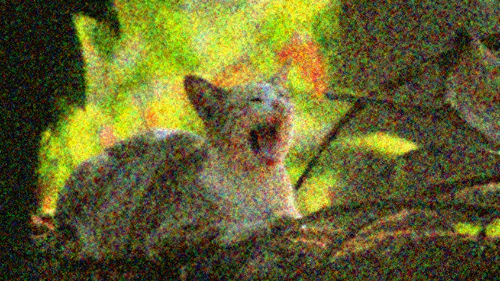

In [ ]:
img = run_deep_dream_with_octaves(img=original_img, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

In [ ]:
def run_deep_dream_with_octaves(img, steps_per_octave=60, step_size=4, 
                                octaves=range(-3,2), octave_scale=0.9):
  base_shape = tf.shape(img)
  img = tf.keras.utils.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  initial_shape = img.shape[:-1]
  img = tf.image.resize(img, initial_shape)
  for octave in octaves:
    # Scale the image based on the octave
    new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
    new_size = tf.cast(new_size, tf.int32)
    img = tf.image.resize(img, new_size)

    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(img, new_size)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

      if step % 10 == 0:
        display.clear_output(wait=True)
        show(deprocess(img))
        print ("Octave {}, Step {}".format(octave, step))
    
  result = deprocess(img)
  return result

This is just the result of having changed the paramteres for the amalgamated function.

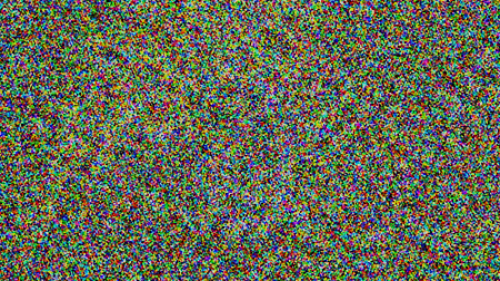

In [ ]:
img = run_deep_dream_with_octaves(img=original_img, step_size=0.08)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/300.0, dtype=tf.uint8)
show(img)

From below starts an implementation I tried using Chollets code from the book, but I kept running into an error where it would exhaust my resources running past 2 octaves which is why I ultimately abandoned it to follow Tensorflows deep dream. 

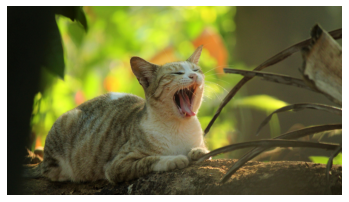

In [ ]:
# Chollet below here
plt.axis("off") 
plt.imshow(keras.utils.load_img(base_image_path))

In [ ]:
from tensorflow.keras.applications import inception_v3
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

In [ ]:
layer_settings = {
    "mixed4": 1.0,
    "mixed5": 1.5,
    "mixed6": 2.0,
    "mixed7": 2.5,
}
outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name)
                      for name in layer_settings.keys()]
    ] 
)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [ ]:
def compute_loss(input_image):
    features = feature_extractor(input_image) 
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :]))
    return loss

In [ ]:
@tf.function
def gradient_ascent_step(image, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image)
    grads = tape.gradient(loss, image) 
    grads = tf.math.l2_normalize(grads) 
    image += learning_rate * grads 
    return loss, image

def gradient_ascent_loop(image, iterations, learning_rate, max_loss=None): 
    for i in range(iterations):
        loss, image = gradient_ascent_step(image, learning_rate) 
        if max_loss is not None and loss > max_loss:
            break
        print(f"... Loss value at step {i}: {loss:.2f}")
    return image

In [ ]:
step = 20.
num_octave = 3
octave_scale = 1.4
iterations = 30
max_loss = 15.

In [ ]:
def preprocess_image(image_path):
    img = keras.utils.load_img(image_path)
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.inception_v3.preprocess_input(img) 
    return img

def deprocess_image(img):
    img = img.reshape((img.shape[1], img.shape[2], 3))
    img /= 2.0
    img += 0.5
    img *= 255.
    img = np.clip(img, 0, 255).astype("uint8") 
    return img

In [ ]:
original_img = preprocess_image(base_image_path) 
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape] 
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape) 
successive_shapes = successive_shapes[::-1]

shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)
for i, shape in enumerate(successive_shapes):
    print(f"Processing octave {i} with shape {shape}") 
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape) 
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

keras.utils.save_img("dream.png", deprocess_image(img.numpy()))

Processing octave 0 with shape (1435, 2551)
... Loss value at step 0: 0.62
... Loss value at step 1: 0.77
... Loss value at step 2: 0.96
... Loss value at step 3: 1.15
... Loss value at step 4: 1.33
... Loss value at step 5: 1.52
... Loss value at step 6: 1.71
... Loss value at step 7: 1.92
... Loss value at step 8: 2.10
... Loss value at step 9: 2.32
... Loss value at step 10: 2.60
... Loss value at step 11: 2.88
... Loss value at step 12: 3.20
... Loss value at step 13: 3.49
... Loss value at step 14: 3.97
... Loss value at step 15: 4.47
... Loss value at step 16: 5.25
... Loss value at step 17: 5.92
... Loss value at step 18: 6.75
... Loss value at step 19: 7.56
... Loss value at step 20: 8.67
... Loss value at step 21: 9.60
... Loss value at step 22: 10.83
... Loss value at step 23: 12.12
... Loss value at step 24: 13.48
... Loss value at step 25: 14.85
Processing octave 1 with shape (2009, 3571)
... Loss value at step 0: 1.11
... Loss value at step 1: 2.46
... Loss value at step 2

ResourceExhaustedError: ignored

# REFERENCE CELL
1. CHAPTER 12 OF DLWP (upto 12.3)
2. TENSORFLOW CORE > GENERATIVE > DEEP DREAM
These are the two places I took code from.